In [1]:
import os, sys
from pathlib import Path
import time

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob

/home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Input parameters

In [2]:
INPUT_PATH = Path("../../data/01-raw")
DEST_PATH = Path("../../data/02-processed")
RESOLUTION = 0.02 # 2 km
CROP_ALLOWANCE_DEG = 13*RESOLUTION
CITY_NAME = 'Dagupan'
YEAR = 2007

### Read bounds

In [3]:
bounds_gdf = gpd.read_file(INPUT_PATH / 'domains' / 'downscaling_domains_fixed.geojson', driver='GeoJSON')
bounds_gdf.head()

,city,geometry
0,Dagupan,"POLYGON ((120.00931 15.90723, 120.52218 15.907..."
1,Palayan,"POLYGON ((120.88251 15.29488, 121.33348 15.294..."
2,MetroManila,"POLYGON ((120.86704 14.29347, 121.20453 14.293..."
3,Legazpi,"POLYGON ((123.65317 12.95603, 123.88749 12.956..."
4,Iloilo,"POLYGON ((122.41374 10.59140, 122.69007 10.591..."


In [4]:
city_bounds_gdf = bounds_gdf[bounds_gdf['city']==CITY_NAME].copy()
city_bounds_gdf

,city,geometry
0,Dagupan,"POLYGON ((120.00931 15.90723, 120.52218 15.907..."


In [5]:
lon0, lat0, lon1, lat1 = city_bounds_gdf.total_bounds
lon0, lat0, lon1, lat1 

(120.00931049408791, 15.907227776604742, 120.52217696368251, 16.36998660261825)

### Create grid

In [6]:
ds_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(lat0, lat1+RESOLUTION, RESOLUTION)),
        "lon": (["lon"], np.arange(lon0, lon1+RESOLUTION, RESOLUTION)),
    }
)
ds_grid

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 27)
Coordinates:
  * lat      (lat) float64 15.91 15.93 15.95 15.97 ... 16.33 16.35 16.37 16.39
  * lon      (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5 120.5
Data variables:
    *empty*

### Align SRTM

In [7]:
elev_ds = xr.open_dataset(INPUT_PATH / 'dem' / f'SRTM_{CITY_NAME}.tiff')
elev_ds = elev_ds.rename({'x': 'lon', 'y': 'lat'})
elev_ds

<xarray.Dataset>
Dimensions:      (band: 1, lon: 1846, lat: 1665)
Coordinates:
  * band         (band) int64 1
  * lon          (lon) float64 120.0 120.0 120.0 120.0 ... 120.5 120.5 120.5
  * lat          (lat) float64 16.37 16.37 16.37 16.37 ... 15.91 15.91 15.91
    spatial_ref  int64 ...
Data variables:
    band_data    (band, lat, lon) float32 ...

In [8]:
elev_regridder = xe.Regridder(elev_ds, ds_grid, "bilinear")
elev_regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_1665x1846_25x27.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1665, 1846) 
Output grid shape:          (25, 27) 
Periodic in longitude?      False

In [9]:
elev_regridded_ds = elev_regridder(elev_ds, keep_attrs=True)
elev_regridded_ds = elev_regridded_ds.rename_vars({'band_data': 'elevation'})
elev_regridded_ds

<xarray.Dataset>
Dimensions:      (band: 1, lat: 25, lon: 27)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 ...
  * lat          (lat) float64 15.91 15.93 15.95 15.97 ... 16.35 16.37 16.39
  * lon          (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5
Data variables:
    elevation    (band, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

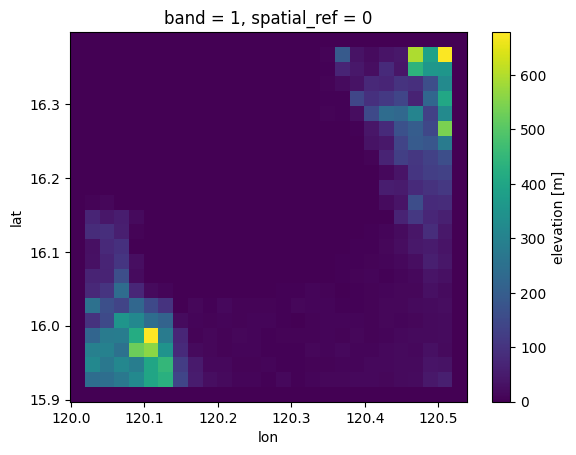

In [10]:
elev_regridded_ds['elevation'].plot()

In [11]:
del elev_ds

In [12]:
#elev_regridded_ds = elev_regridded_ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
elev_regridded_ds.to_netcdf(DEST_PATH / 'input' / f"srtm_regridded_{CITY_NAME.lower()}.nc", engine="scipy")

## Align NDVI

In [14]:
from functools import partial
def _preprocess(ds, lon_bnds, lat_bnds):
    return ds.sel(x=slice(*lon_bnds), y=slice(*lat_bnds))

In [15]:
ndvi_fns =  list((INPUT_PATH / 'ndvi' ).glob(f'NDVI_PH_{YEAR}*.nc'))
ndvi_fns

[PosixPath('../../data/01-raw/ndvi/NDVI_PH_200701.nc'),
 PosixPath('../../data/01-raw/ndvi/NDVI_PH_200702.nc'),
 PosixPath('../../data/01-raw/ndvi/NDVI_PH_200703.nc'),
 PosixPath('../../data/01-raw/ndvi/NDVI_PH_200704.nc'),
 PosixPath('../../data/01-raw/ndvi/NDVI_PH_200705.nc'),
 PosixPath('../../data/01-raw/ndvi/NDVI_PH_200706.nc'),
 PosixPath('../../data/01-raw/ndvi/NDVI_PH_200707.nc'),
 PosixPath('../../data/01-raw/ndvi/NDVI_PH_200708.nc'),
 PosixPath('../../data/01-raw/ndvi/NDVI_PH_200709.nc'),
 PosixPath('../../data/01-raw/ndvi/NDVI_PH_200710.nc'),
 PosixPath('../../data/01-raw/ndvi/NDVI_PH_200711.nc'),
 PosixPath('../../data/01-raw/ndvi/NDVI_PH_200712.nc')]

In [16]:
lon_bnds, lat_bnds = (lon0-CROP_ALLOWANCE_DEG, lon1+CROP_ALLOWANCE_DEG), (lat1+CROP_ALLOWANCE_DEG, lat0 - CROP_ALLOWANCE_DEG)
partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
ndvi_fns = list((INPUT_PATH / 'ndvi' ).glob(f'NDVI_PH_{YEAR}*.nc'))
ds = xr.open_mfdataset(ndvi_fns, preprocess=partial_func, drop_variables=['EVI'])
ndvi_ds = ds.reindex(y=list(reversed(ds.y)))
ndvi_ds = ndvi_ds.rename({'x': 'lon', 'y': 'lat'})
ndvi_ds = ndvi_ds.rename({'NDVI_gapfill' : 'ndvi'})
ndvi_ds 


<xarray.Dataset>
Dimensions:      (band: 1, lon: 21, lat: 20, time: 365)
Coordinates:
  * band         (band) int64 1
  * lon          (lon) float64 119.8 119.8 119.9 119.9 ... 120.7 120.7 120.8
  * lat          (lat) float64 15.67 15.72 15.77 15.82 ... 16.52 16.57 16.62
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
Data variables:
    ndvi         (time, band, lat, lon) float32 dask.array<chunksize=(31, 1, 20, 21), meta=np.ndarray>
    spatial_ref  (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes: (12/39)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDINSTRUMENTSHORTNAME.2:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ASSOCIATEDPLATFORMSHORTNAME.2:      Aqua
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    ASSOCIATEDSENSORSHORTNAME.2:        MODIS
    ...                                 ...
    SCIENCEQUALITYFLAGEXPLANATION.1:    See http://landweb.nascom/nasa.gov/cg...
    SHORTNAME:                          MCD19A3CMG
    SOUTHBOUNDINGCOORDINATE:            -90.0
    SPSOPARAMETERS:                     None
    VERSIONID:                          61
    WESTBOUNDINGCOORDINATE:             -180.0

In [20]:
ndvi_regridder = xe.Regridder(ndvi_ds, ds_grid, "bilinear")
ndvi_regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_20x21_25x27.nc 
Reuse pre-computed weights? False 
Input grid shape:           (20, 21) 
Output grid shape:          (25, 27) 
Periodic in longitude?      False

In [21]:
ndvi_regridded_ds = ndvi_regridder(ndvi_ds, keep_attrs=True)
ndvi_regridded_ds

<xarray.Dataset>
Dimensions:  (time: 365, band: 1, lat: 25, lon: 27)
Coordinates:
  * band     (band) int64 1
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lat      (lat) float64 15.91 15.93 15.95 15.97 ... 16.33 16.35 16.37 16.39
  * lon      (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5 120.5
Data variables:
    ndvi     (time, band, lat, lon) float32 dask.array<chunksize=(31, 1, 20, 21), meta=np.ndarray>
Attributes: (12/40)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDINSTRUMENTSHORTNAME.2:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ASSOCIATEDPLATFORMSHORTNAME.2:      Aqua
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    ASSOCIATEDSENSORSHORTNAME.2:        MODIS
    ...                                 ...
    SHORTNAME:                          MCD19A3CMG
    SOUTHBOUNDINGCOORDINATE:            -90.0
    SPSOPARAMETERS:                     None
    VERSIONID:                          61
    WESTBOUNDINGCOORDINATE:             -180.0
    regrid_method:                      bilinear

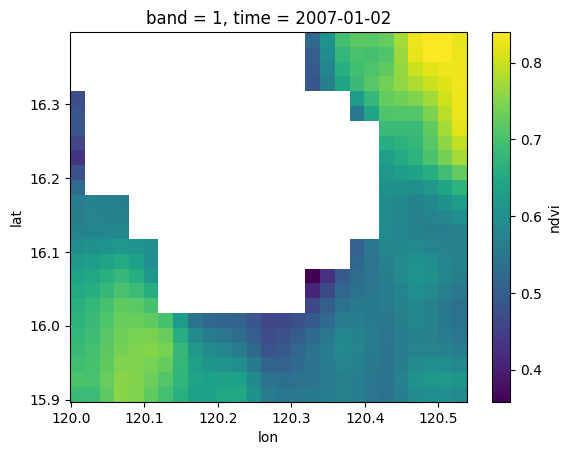

In [206]:
ndvi_regridded_ds.isel(time=1)['ndvi'].plot()

In [207]:
ndvi_regridded_ds

<xarray.Dataset>
Dimensions:  (time: 365, band: 1, lat: 25, lon: 27)
Coordinates:
  * band     (band) int64 1
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lat      (lat) float64 15.91 15.93 15.95 15.97 ... 16.33 16.35 16.37 16.39
  * lon      (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5 120.5
Data variables:
    ndvi     (time, band, lat, lon) float32 dask.array<chunksize=(31, 1, 20, 21), meta=np.ndarray>
Attributes: (12/40)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDINSTRUMENTSHORTNAME.2:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ASSOCIATEDPLATFORMSHORTNAME.2:      Aqua
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    ASSOCIATEDSENSORSHORTNAME.2:        MODIS
    ...                                 ...
    SHORTNAME:                          MCD19A3CMG
    SOUTHBOUNDINGCOORDINATE:            -90.0
    SPSOPARAMETERS:                     None
    VERSIONID:                          61
    WESTBOUNDINGCOORDINATE:             -180.0
    regrid_method:                      bilinear

In [209]:
ndvi_regridded_ds.to_netcdf(DEST_PATH / 'input' / f"ndvi_regridded_{CITY_NAME.lower()}.nc", engine="scipy")

## Align ERA5

In [210]:
def _preprocess(ds, lon_bnds, lat_bnds):
    return ds.sel(longitude=slice(*lon_bnds), latitude=slice(*lat_bnds))

In [211]:
era5_fns =  list((INPUT_PATH / 'era5' ).glob(f'ERA5_PH_{YEAR}*.nc'))
era5_fns

[PosixPath('../../data/01-raw/era5/ERA5_PH_200701.nc'),
 PosixPath('../../data/01-raw/era5/ERA5_PH_200702.nc'),
 PosixPath('../../data/01-raw/era5/ERA5_PH_200703.nc'),
 PosixPath('../../data/01-raw/era5/ERA5_PH_200704.nc'),
 PosixPath('../../data/01-raw/era5/ERA5_PH_200705.nc'),
 PosixPath('../../data/01-raw/era5/ERA5_PH_200706.nc'),
 PosixPath('../../data/01-raw/era5/ERA5_PH_200707.nc'),
 PosixPath('../../data/01-raw/era5/ERA5_PH_200708.nc'),
 PosixPath('../../data/01-raw/era5/ERA5_PH_200709.nc'),
 PosixPath('../../data/01-raw/era5/ERA5_PH_200710.nc'),
 PosixPath('../../data/01-raw/era5/ERA5_PH_200711.nc'),
 PosixPath('../../data/01-raw/era5/ERA5_PH_200712.nc')]

In [212]:
lon_bnds, lat_bnds = (lon0-CROP_ALLOWANCE_DEG, lon1+CROP_ALLOWANCE_DEG), (lat1+CROP_ALLOWANCE_DEG, lat0 - CROP_ALLOWANCE_DEG)
partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
era5_fns = list((INPUT_PATH / 'era5' ).glob(f'ERA5_PH_{YEAR}*.nc'))
ds = xr.open_mfdataset(era5_fns, preprocess=partial_func)
#era5_ds = era_ds.reindex(y=list(reversed(ds.y)))
era5_ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
era5_ds


<xarray.Dataset>
Dimensions:  (time: 8760, lat: 4, lon: 5)
Coordinates:
  * lon      (lon) float32 119.8 120.0 120.2 120.5 120.8
  * lat      (lat) float32 16.5 16.25 16.0 15.75
  * time     (time) datetime64[ns] 2007-01-01 ... 2007-12-31T23:00:00
Data variables:
    u10      (time, lat, lon) float32 dask.array<chunksize=(744, 4, 5), meta=np.ndarray>
    v10      (time, lat, lon) float32 dask.array<chunksize=(744, 4, 5), meta=np.ndarray>
    d2m      (time, lat, lon) float32 dask.array<chunksize=(744, 4, 5), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(744, 4, 5), meta=np.ndarray>
    sp       (time, lat, lon) float32 dask.array<chunksize=(744, 4, 5), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(744, 4, 5), meta=np.ndarray>
    tcc      (time, lat, lon) float32 dask.array<chunksize=(744, 4, 5), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-20 08:14:23 GMT by grib_to_netcdf-2.28.0: grib_to_n...

In [213]:
era5_ds_mean = era5_ds.resample(time='1D').mean()
for variable in [v for v in list(era5_ds_mean.variables.keys()) if v not in ['lon','lat','time']] :
    era5_ds_mean = era5_ds_mean.rename({variable : f"{variable}_mean"})

era5_ds_min = era5_ds.resample(time='1D').min()
for variable in [v for v in list(era5_ds_min.variables.keys()) if v not in ['lon','lat','time']] :
    era5_ds_min = era5_ds_min.rename({variable : f"{variable}_min"})

era5_ds_max = era5_ds.resample(time='1D').max()
for variable in [v for v in list(era5_ds_max.variables.keys()) if v not in ['lon','lat','time']] :
    era5_ds_max = era5_ds_max.rename({variable : f"{variable}_max"})

era_ds_merged = xr.merge([era5_ds_mean, era5_ds_min, era5_ds_max])
era_ds_merged

<xarray.Dataset>
Dimensions:   (time: 365, lat: 4, lon: 5)
Coordinates:
  * lon       (lon) float32 119.8 120.0 120.2 120.5 120.8
  * lat       (lat) float32 16.5 16.25 16.0 15.75
  * time      (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
Data variables: (12/21)
    u10_mean  (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    v10_mean  (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    d2m_mean  (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    t2m_mean  (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    sp_mean   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    tp_mean   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    ...        ...
    v10_max   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    d2m_max   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    t2m_max   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    sp_max    (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    tp_max    (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    tcc_max   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-20 08:14:23 GMT by grib_to_netcdf-2.28.0: grib_to_n...

In [214]:
era5_regridder = xe.Regridder(era_ds_merged, ds_grid, "bilinear")
era5_regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_4x5_25x27.nc 
Reuse pre-computed weights? False 
Input grid shape:           (4, 5) 
Output grid shape:          (25, 27) 
Periodic in longitude?      False

In [215]:
era5_regridded_ds = era5_regridder(era_ds_merged, keep_attrs=True)
era5_regridded_ds

/home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/home/jace/miniconda3/envs/climate-downscaling/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/home/jace/miniconda

<xarray.Dataset>
Dimensions:   (time: 365, lat: 25, lon: 27)
Coordinates:
  * time      (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lat       (lat) float64 15.91 15.93 15.95 15.97 ... 16.33 16.35 16.37 16.39
  * lon       (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5 120.5
Data variables: (12/21)
    u10_mean  (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    v10_mean  (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    d2m_mean  (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    t2m_mean  (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    sp_mean   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    tp_mean   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    ...        ...
    v10_max   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    d2m_max   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    t2m_max   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    sp_max    (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    tp_max    (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    tcc_max   (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.6
    history:        2024-03-20 08:14:23 GMT by grib_to_netcdf-2.28.0: grib_to...
    regrid_method:  bilinear

In [216]:
era5_regridded_ds.to_netcdf(DEST_PATH / 'input' / f"era5_regridded_{CITY_NAME.lower()}.nc", engine="scipy")

## Align CHIRTS

In [217]:
def _preprocess(ds, lon_bnds, lat_bnds):
    return ds.sel(longitude=slice(*lon_bnds), latitude=slice(*lat_bnds))

In [218]:
lon_bnds, lat_bnds = (lon0-CROP_ALLOWANCE_DEG, lon1+CROP_ALLOWANCE_DEG), (lat0 - CROP_ALLOWANCE_DEG, lat1+CROP_ALLOWANCE_DEG)
partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
chirts_fns = list((INPUT_PATH / 'chirts' ).glob(f'CHIRTS_Tmax_PH_{YEAR}*.nc'))
ds = xr.open_mfdataset(chirts_fns, preprocess=partial_func)
chirts_tmax_ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
chirts_tmax_ds


<xarray.Dataset>
Dimensions:  (lat: 20, lon: 21, time: 365)
Coordinates:
  * lat      (lat) float32 15.67 15.72 15.77 15.82 ... 16.47 16.52 16.57 16.62
  * lon      (lon) float32 119.8 119.8 119.9 119.9 ... 120.6 120.7 120.7 120.8
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
Data variables:
    Tmax     (time, lat, lon) float32 dask.array<chunksize=(1, 20, 21), meta=np.ndarray>
Attributes: (12/15)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    https_url:      https://data.chc.ucsb.edu/products/CHIRTSdaily/v1.0/globa...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...

In [219]:
lon_bnds, lat_bnds = (lon0-CROP_ALLOWANCE_DEG, lon1+CROP_ALLOWANCE_DEG), (lat0 - CROP_ALLOWANCE_DEG, lat1+CROP_ALLOWANCE_DEG)
partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
chirts_fns = list((INPUT_PATH / 'chirts' ).glob(f'CHIRTS_Tmin_PH_{YEAR}*.nc'))
ds = xr.open_mfdataset(chirts_fns, preprocess=partial_func)
chirts_tmin_ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
chirts_tmin_ds


<xarray.Dataset>
Dimensions:  (lat: 20, lon: 21, time: 365)
Coordinates:
  * lat      (lat) float32 15.67 15.72 15.77 15.82 ... 16.47 16.52 16.57 16.62
  * lon      (lon) float32 119.8 119.8 119.9 119.9 ... 120.6 120.7 120.7 120.8
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
Data variables:
    Tmin     (time, lat, lon) float32 dask.array<chunksize=(1, 20, 21), meta=np.ndarray>
Attributes: (12/15)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    https_url:      https://data.chc.ucsb.edu/products/CHIRTSdaily/v1.0/globa...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...

In [220]:
chirts_regridder = xe.Regridder(chirts_tmin_ds, ds_grid, "bilinear")
chirts_regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_20x21_25x27.nc 
Reuse pre-computed weights? False 
Input grid shape:           (20, 21) 
Output grid shape:          (25, 27) 
Periodic in longitude?      False

In [221]:
chirts_tmax_regridded_ds = chirts_regridder(chirts_tmax_ds, keep_attrs=True)
chirts_tmax_regridded_ds 

<xarray.Dataset>
Dimensions:  (time: 365, lat: 25, lon: 27)
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lat      (lat) float64 15.91 15.93 15.95 15.97 ... 16.33 16.35 16.37 16.39
  * lon      (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5 120.5
Data variables:
    Tmax     (time, lat, lon) float32 dask.array<chunksize=(1, 20, 21), meta=np.ndarray>
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

In [222]:
chirts_tmin_regridded_ds = chirts_regridder(chirts_tmin_ds, keep_attrs=True)
chirts_tmin_regridded_ds 

<xarray.Dataset>
Dimensions:  (time: 365, lat: 25, lon: 27)
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lat      (lat) float64 15.91 15.93 15.95 15.97 ... 16.33 16.35 16.37 16.39
  * lon      (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5 120.5
Data variables:
    Tmin     (time, lat, lon) float32 dask.array<chunksize=(1, 20, 21), meta=np.ndarray>
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

In [223]:
chirts_regridded_ds = xr.merge([chirts_tmin_regridded_ds, chirts_tmax_regridded_ds])
for variable in [v for v in list(chirts_regridded_ds.variables.keys()) if v not in ['lon','lat','time']] :
    chirts_regridded_ds = chirts_regridded_ds.rename({variable : variable.lower()})
chirts_regridded_ds 

<xarray.Dataset>
Dimensions:  (time: 365, lat: 25, lon: 27)
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lat      (lat) float64 15.91 15.93 15.95 15.97 ... 16.33 16.35 16.37 16.39
  * lon      (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5 120.5
Data variables:
    tmin     (time, lat, lon) float32 dask.array<chunksize=(1, 20, 21), meta=np.ndarray>
    tmax     (time, lat, lon) float32 dask.array<chunksize=(1, 20, 21), meta=np.ndarray>
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

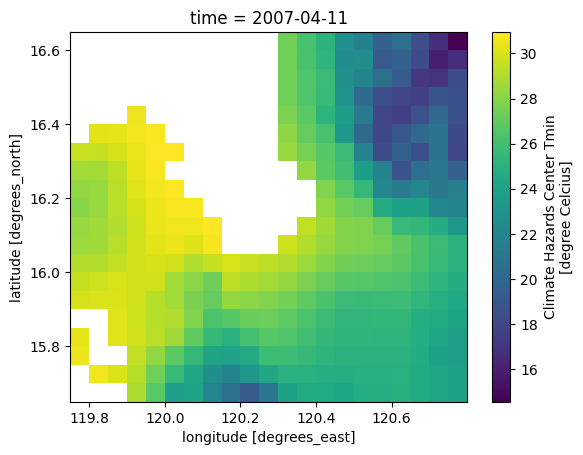

In [235]:
chirts_tmin_ds.isel(time=100)['Tmin'].plot()

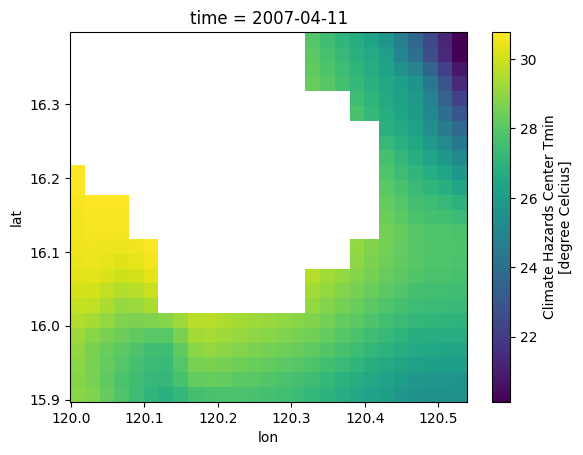

In [237]:
chirts_regridded_ds.isel(time=100)['tmin'].plot()

In [225]:
chirts_regridded_ds.to_netcdf(DEST_PATH / 'input' / f"chirts_regridded_{CITY_NAME.lower()}.nc", engine="scipy")

## Align CHIRPS

In [226]:
lon_bnds, lat_bnds = (lon0-CROP_ALLOWANCE_DEG, lon1+CROP_ALLOWANCE_DEG), (lat0 - CROP_ALLOWANCE_DEG, lat1+CROP_ALLOWANCE_DEG)
partial_func = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
chirps_fns = list((INPUT_PATH / 'chirps' ).glob(f'CHIRPS_PH_{YEAR}*.nc'))
ds = xr.open_mfdataset(chirps_fns, preprocess=partial_func)
chirps_ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
chirps_ds


<xarray.Dataset>
Dimensions:  (time: 365, lat: 20, lon: 21)
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lat      (lat) float32 15.67 15.72 15.77 15.82 ... 16.47 16.52 16.57 16.62
  * lon      (lon) float32 119.8 119.8 119.9 119.9 ... 120.6 120.7 120.7 120.8
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(365, 20, 21), meta=np.ndarray>
Attributes: (12/31)
    acknowledgements:          The Climate Hazards Group InfraRed Precipitati...
    cdm_data_type:             Grid
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             pete@geog.ucsb.edu
    creator_name:              Pete Peterson
    creator_type:              person
    ...                        ...
    summary:                   This dataset has 1-day (daily) averages of the...
    time_coverage_end:         2007-12-31T00:00:00Z
    time_coverage_start:       2007-01-01T00:00:00Z
    title:                     CHIRPS Version 2.0, Precipitation, Global, 0.0...
    version:                   2.0
    Westernmost_Easting:       116.524994

In [227]:
chirps_regridder = xe.Regridder(chirps_ds, ds_grid, "bilinear")
chirps_regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_20x21_25x27.nc 
Reuse pre-computed weights? False 
Input grid shape:           (20, 21) 
Output grid shape:          (25, 27) 
Periodic in longitude?      False

In [228]:
chirps_regridded_ds = chirps_regridder(chirps_ds, keep_attrs=True)
chirps_regridded_ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 25, lon: 27)
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lat      (lat) float64 15.91 15.93 15.95 15.97 ... 16.33 16.35 16.37 16.39
  * lon      (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5 120.5
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(365, 20, 21), meta=np.ndarray>
Attributes: (12/32)
    acknowledgements:          The Climate Hazards Group InfraRed Precipitati...
    cdm_data_type:             Grid
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             pete@geog.ucsb.edu
    creator_name:              Pete Peterson
    creator_type:              person
    ...                        ...
    time_coverage_end:         2007-12-31T00:00:00Z
    time_coverage_start:       2007-01-01T00:00:00Z
    title:                     CHIRPS Version 2.0, Precipitation, Global, 0.0...
    version:                   2.0
    Westernmost_Easting:       116.524994
    regrid_method:             bilinear

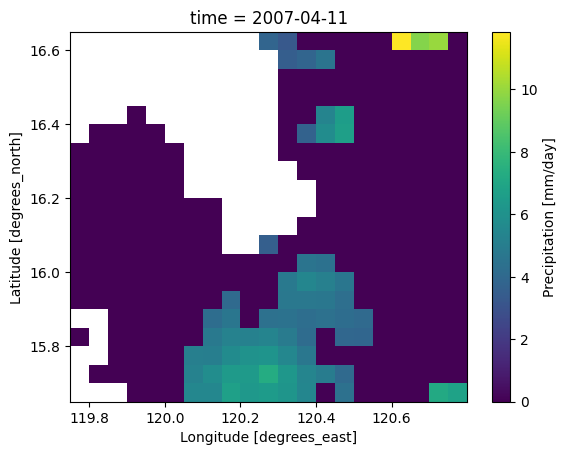

In [238]:
chirps_ds.isel(time=100)['precip'].plot()

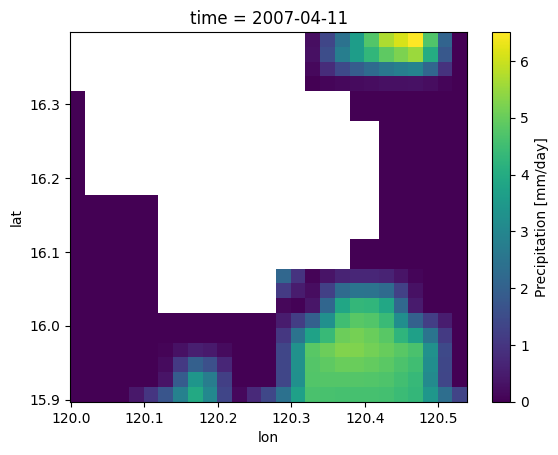

In [239]:
chirps_regridded_ds.isel(time=100)['precip'].plot()

In [229]:
chirps_regridded_ds.to_netcdf(DEST_PATH / 'input' / f"chirps_regridded_{CITY_NAME.lower()}.nc", engine="scipy")

## Merge all aligned

In [230]:
all_ds = xr.merge([elev_regridded_ds, ndvi_regridded_ds, era5_regridded_ds, chirts_regridded_ds, chirps_regridded_ds])
all_ds

<xarray.Dataset>
Dimensions:      (band: 1, lat: 25, lon: 27, time: 365)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 ...
  * lat          (lat) float64 15.91 15.93 15.95 15.97 ... 16.35 16.37 16.39
  * lon          (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
Data variables: (12/26)
    elevation    (band, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ndvi         (time, band, lat, lon) float32 dask.array<chunksize=(31, 1, 20, 21), meta=np.ndarray>
    u10_mean     (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    v10_mean     (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    d2m_mean     (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    t2m_mean     (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    ...           ...
    sp_max       (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    tp_max       (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    tcc_max      (time, lat, lon) float32 dask.array<chunksize=(31, 4, 5), meta=np.ndarray>
    tmin         (time, lat, lon) float32 dask.array<chunksize=(1, 20, 21), meta=np.ndarray>
    tmax         (time, lat, lon) float32 dask.array<chunksize=(1, 20, 21), meta=np.ndarray>
    precip       (time, lat, lon) float32 dask.array<chunksize=(365, 20, 21), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [231]:
all_ds.isel(time=1)

<xarray.Dataset>
Dimensions:      (band: 1, lat: 25, lon: 27)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 ...
  * lat          (lat) float64 15.91 15.93 15.95 15.97 ... 16.35 16.37 16.39
  * lon          (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5
    time         datetime64[ns] 2007-01-02
Data variables: (12/26)
    elevation    (band, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ndvi         (band, lat, lon) float32 dask.array<chunksize=(1, 20, 21), meta=np.ndarray>
    u10_mean     (lat, lon) float32 dask.array<chunksize=(4, 5), meta=np.ndarray>
    v10_mean     (lat, lon) float32 dask.array<chunksize=(4, 5), meta=np.ndarray>
    d2m_mean     (lat, lon) float32 dask.array<chunksize=(4, 5), meta=np.ndarray>
    t2m_mean     (lat, lon) float32 dask.array<chunksize=(4, 5), meta=np.ndarray>
    ...           ...
    sp_max       (lat, lon) float32 dask.array<chunksize=(4, 5), meta=np.ndarray>
    tp_max       (lat, lon) float32 dask.array<chunksize=(4, 5), meta=np.ndarray>
    tcc_max      (lat, lon) float32 dask.array<chunksize=(4, 5), meta=np.ndarray>
    tmin         (lat, lon) float32 dask.array<chunksize=(20, 21), meta=np.ndarray>
    tmax         (lat, lon) float32 dask.array<chunksize=(20, 21), meta=np.ndarray>
    precip       (lat, lon) float32 dask.array<chunksize=(20, 21), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [232]:
all_ds.to_netcdf(DEST_PATH / 'input' / f"all_vars_regridded_{CITY_NAME.lower()}.nc", engine="scipy")